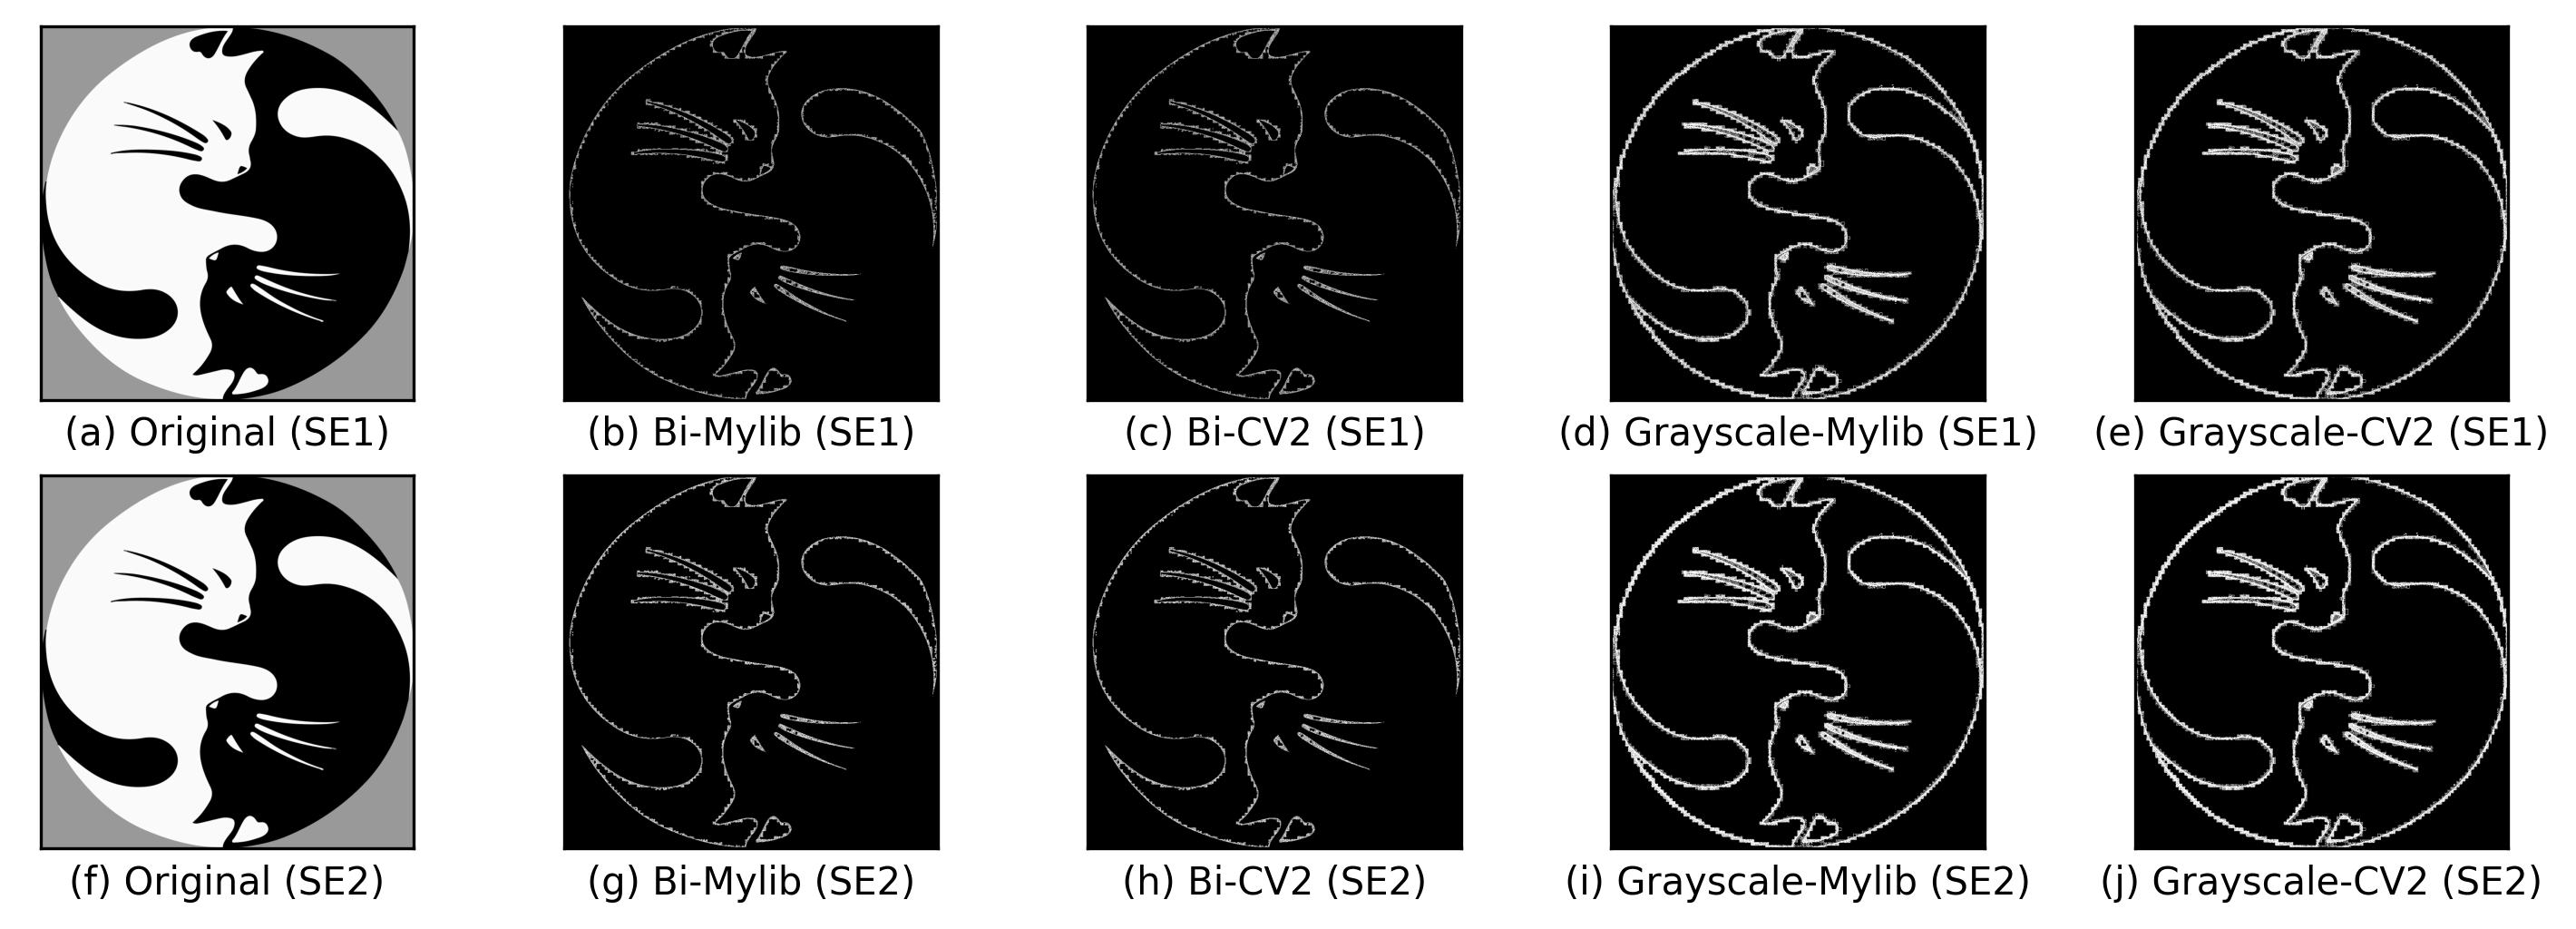

In [8]:
#!/usr/bin/env python3

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
%run spatial_filter.ipynb

class BoundaryExtraction(SpatialFilter):
    def __init__(self):
        super().__init__("morphology")
    
    def enhance_boundary(self, img: cv2.Mat):
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] == 0:
                    img[i][j] = 0
                else:
                    img[i][j] = 255    
        return img
    
    def binarize(self, img: cv2.Mat):
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] > 248:
                    img[i][j] = 1
                else:
                    img[i][j] = 0
        return img
    
    def apply_grayscale_img(self, image_path, se, lib="cv2"):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if lib == "cv2":
            res = cv2.morphologyEx(image, cv2.MORPH_ERODE, se)
        elif lib == "mylib":
            new_image = image.copy()
            def fit_min_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                # pad the partial image to (kernel_size, kernel_size)
                padded_partial_image = np.zeros((len(se[0]), len(se[0])))
                padded_partial_image.fill(255)
                padded_partial_image[:partial_image.shape[0], :partial_image.shape[1]] = partial_image
                # compute the new value
                min_val = 255
                for k in range(len(se[0])):
                    for l in range(len(se[0])):
                        if se[k][l] == 1 and padded_partial_image[k][l] < min_val:
                            min_val = padded_partial_image[k][l]
                new_image[i][j] = min_val

            super().util_move_kernel(image, len(se[0]), new_image, fit_min_hook)
            res = new_image
        else:
            raise Exception("Unknown library")
        # substraction
        res = image - res
        return res
    
    def apply_binary_img(self, image_path, se, lib="cv2"):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = self.binarize(image)
        if lib == "cv2":
            res = cv2.morphologyEx(image, cv2.MORPH_ERODE, se)
        elif lib == "mylib":
            new_image = image.copy()
            def fit_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                # pad the partial image to (kernel_size, kernel_size)
                padded_partial_image = np.zeros((len(se[0]), len(se[0])))
                padded_partial_image[:partial_image.shape[0], :partial_image.shape[1]] = partial_image
                fit = True
                # compute the new value
                for k in range(len(se[0])):
                    for l in range(len(se[0])):
                        if se[k][l] == 1 and padded_partial_image[k][l] == 0:
                            fit = False
                            break
                    if not fit:
                        break
                if fit:
                    new_image[i][j] = 1
                else:
                    new_image[i][j] = 0

            super().util_move_kernel(image, len(se[0]), new_image, fit_hook)
            res = new_image
        else:
            raise Exception("Unknown library")
        # substraction
        res = image - res
        return res

be = BoundaryExtraction()
se1 = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
se2 = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.uint8)

fig = plt.figure(figsize=(12, 4), dpi=300)
images = [ "./Q2_image/Figure_2.jpg", 
           "./Q2_image/Figure_2.jpg", 
           "./Q2_image/Figure_2.jpg", 
           "./Q2_image/Figure_2.jpg", 
           "./Q2_image/Figure_2.jpg" ]
titles = [ "Original", "Bi-Mylib", "Bi-CV2", "Grayscale-Mylib", "Grayscale-CV2" ]
funcs = [ None, be.apply_binary_img, be.apply_binary_img, be.apply_grayscale_img, be.apply_grayscale_img ]
libs = [ None, "mylib", "cv2", "mylib", "cv2" ]
ses = [se1, se2]

for se_id, se in enumerate(ses):
    for i in range(len(images)):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(len(ses), len(images), se_id * len(images) + i + 1)
        plt.xticks([])
        plt.yticks([])

        def convert_id_to_char(id):
            return chr(id + 96)
        
        plt.xlabel("(" + convert_id_to_char(se_id * len(images) + i + 1) + ") " + titles[i] + " (SE{})".format(se_id + 1))
        if funcs[i] is not None:
            img = funcs[i](images[i], se, libs[i])
            img = be.enhance_boundary(img)
        plt.imshow(img, cmap="gray")
        if i != 0:
            cv2.imwrite("./Morphology/output_{}.png".format(titles[i] + " (SE{})".format(se_id + 1)), img)
plt.savefig("./Morphology/result.jpeg", pad_inches=0)
